# Introducción  a los Sistemas Inteligentes
# 2018-2
# CNN for image classification in Keras

## Download data

This is a dataset of images of cats and dogs that was extacted from this [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats/data). 

The file can be manually download from [here](https://drive.google.com/file/d/1Ys08yalsbM29fvvPhyDxv-SV7TBg3VxK/view?usp=sharing)

In [1]:
!wget -O cnn_data.zip "https://drive.google.com/uc?export=download&id=1Ys08yalsbM29fvvPhyDxv-SV7TBg3VxK"

/bin/sh: wget: command not found


After downloading the file, we uncompress it*

In [2]:
!unzip cnn_data.zip > /dev/null


This creates the folder `data`:

In [3]:
!ls -la data


total 24
drwxr-xr-x@  5 lorena  staff    170 Jul  5 13:04 .
drwxr-xr-x  15 lorena  staff    510 Dec 22 20:10 ..
-rw-r--r--@  1 lorena  staff  10244 Jul  5 13:10 .DS_Store
drwxr-xr-x@  5 lorena  staff    170 Jul  5 13:04 train
drwxr-xr-x@  5 lorena  staff    170 Jul  5 13:04 validation


The following code loads and show an image from the dataset:

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


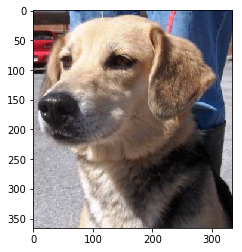

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('data/train/dog/dog.125.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)

## Data augmentation

The goal of *data augmentation* is to extend the training data set by applying different transformations to the original images. The transformation include: rotations, translations, scale change, etc. This is done by the `ImageDataGenerator` class.

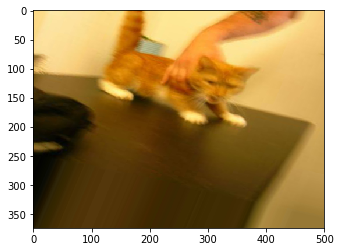

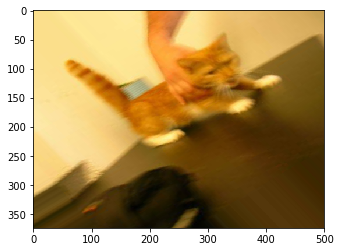

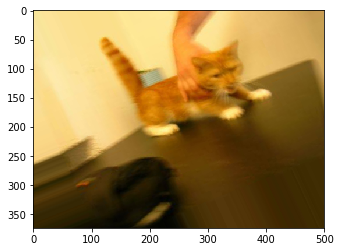

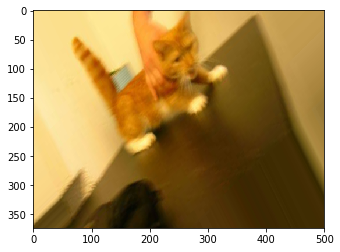

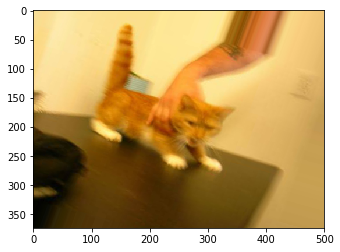

In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cat/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 5:
        break  # otherwise the generator would loop indefinitely
    plt.imshow(batch[0]/255) 
    plt.show()


## Conv Net for Dog-Cat discrimination

Training variables

In [7]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 400
epochs = 50
batch_size = 16

The convolutional network model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [10]:
epochs = 20
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
125/125 [==============================] - 111s 886ms/step - loss: 0.7289 - acc: 0.5130 - val_loss: 0.6859 - val_acc: 0.5075
Epoch 2/20
125/125 [==============================] - 93s 742ms/step - loss: 0.6961 - acc: 0.5725 - val_loss: 0.6360 - val_acc: 0.6550
Epoch 3/20
125/125 [==============================] - 94s 753ms/step - loss: 0.6610 - acc: 0.6305 - val_loss: 0.6142 - val_acc: 0.6625
Epoch 4/20
125/125 [==============================] - 97s 777ms/step - loss: 0.6221 - acc: 0.6750 - val_loss: 0.6254 - val_acc: 0.6425
Epoch 5/20
125/125 [==============================] - 94s 750ms/step - loss: 0.5959 - acc: 0.6875 - val_loss: 0.5671 - val_acc: 0.6900
Epoch 6/20
125/125 [==============================] - 93s 745ms/step - loss: 0.5913 - acc: 0.7075 - val_loss: 0.5700 - val_acc: 0.7125
Epoch 7/20
125/125 [==============================] - 92s 737ms/step - loss: 0.5655 - acc: 0.7235 - val_loss: 0.6195 - val_acc: 0.6575
Epoch 8/20
125/125 [==============================] - 

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16741052153865521020
]


In [12]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


## Testing the classifier

We will use the validation generator to generate one batch of samples and we'll pass them to the model

[0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
[[0.73493147]
 [0.43189535]
 [0.8144028 ]
 [0.15966226]
 [0.6444376 ]
 [0.99999857]
 [0.38146976]
 [0.1733888 ]
 [0.68050987]
 [0.52318186]
 [0.30212227]
 [0.6221797 ]
 [0.10490497]
 [0.17460865]
 [0.04132708]
 [0.99993694]]


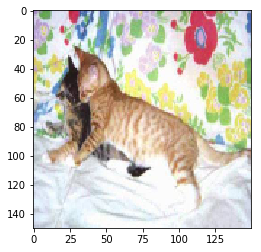

In [13]:
for x_batch, y_batch in validation_generator:
  plt.imshow(x_batch[0])
  print(y_batch)
  print(model.predict_proba(x_batch))
  break

## Transfer Learning

We will use a pretrained image classification model from Keras. They are documented [here](https://keras.io/applications/)

In [14]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 128, 128

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 400
epochs = 50
batch_size = 16

datagen = ImageDataGenerator(rescale=1. / 255)

# build the MobileNet network
model = applications.MobileNet(include_top=False, weights='imagenet'
                               , input_shape=(img_width, img_height, 3))

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size)

np.save('bottleneck_features_train.npy',
        bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = model.predict_generator(
    generator, nb_validation_samples // batch_size)
np.save('bottleneck_features_validation.npy',
        bottleneck_features_validation)

17227776/17225924 [==============================] - 24s 1us/step
Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
bottleneck_features_validation.shape

(400, 4, 4, 1024)

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [ ]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array(
    [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array(
    [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

model_1 = Sequential()
model_1.add(Flatten(input_shape=train_data.shape[1:]))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model_1.save_weights(top_model_weights_path)

Train on 2000 samples, validate on 400 samples
Epoch 1/50
2000/2000 [==============================] - 3s 1ms/step - loss: 1.3166 - acc: 0.8925 - val_loss: 0.4315 - val_acc: 0.9600
Epoch 2/50
2000/2000 [==============================] - 1s 678us/step - loss: 0.6136 - acc: 0.9510 - val_loss: 0.3957 - val_acc: 0.9550
Epoch 3/50
2000/2000 [==============================] - 1s 671us/step - loss: 0.4563 - acc: 0.9630 - val_loss: 0.6947 - val_acc: 0.9500
Epoch 4/50
2000/2000 [==============================] - 1s 667us/step - loss: 0.4438 - acc: 0.9640 - val_loss: 0.4113 - val_acc: 0.9700
Epoch 5/50
2000/2000 [==============================] - 1s 666us/step - loss: 0.3468 - acc: 0.9730 - val_loss: 0.3374 - val_acc: 0.9775
Epoch 6/50
2000/2000 [==============================] - 1s 668us/step - loss: 0.2895 - acc: 0.9790 - val_loss: 0.6203 - val_acc: 0.9525
Epoch 7/50
2000/2000 [==============================] - 1s 662us/step - loss: 0.2941 - acc: 0.9785 - val_loss: 0.4317 - val_acc: 0.9650
Epo

In [ ]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 4,194,817
Trainable params: 4,194,817
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

for x_batch, y_batch in validation_generator:
  print(y_batch)
  print(model_1.predict_proba(model.predict(x_batch)))
  break


Found 400 images belonging to 2 classes.
[1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
[[1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.8181911e-06]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
